# Deep Learning Solutions for identification of Gout Flares using NLP

In [1421]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tinkuacchu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tinkuacchu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tinkuacchu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tinkuacchu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [1496]:
# Standard library imports
from collections import Counter

# Third-party library imports
import contractions
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
import spacy
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional, Dense, Dropout, Embedding, GlobalAveragePooling1D, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn import model_selection # Added this as sklearn was imported but model_selection wasn't directly used
from tensorflow.keras.layers import  Conv1D
# No local application/library imports in this list

In [1497]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tinkuacchu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [1498]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tinkuacchu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [1499]:
#reading the dataset here \t is used to seperate the columns based on the dataset
complaints = pd.read_csv("GOUT-CC-2020-CORPUS-REDACTED.tsv", sep="\t")

In [1500]:
#Gives information about the columns such as constraint, datatype
complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8137 entries, 0 to 8136
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Chief Complaint  8137 non-null   object
 1   Predict          8137 non-null   object
 2   Consensus        8137 non-null   object
dtypes: object(3)
memory usage: 190.8+ KB


In [1501]:
complaints.head()

,Chief Complaint,Predict,Consensus
0,"""I dont know whats going on with my head, its ...",N,-
1,"""i've been depressed for a few weeks now, i'm ...",N,-
2,"Altercation while making arrest, c/o R hand pa...",N,N
3,Cut on L upper thigh wtih saw. Bleeding contro...,N,N
4,"Dysuria x1 week. hx: hysterectomy, gerd, bipolar",N,-


In [1502]:
#Used to count the different values present in Predict column of complaint dataframe
complaints['Predict'].value_counts()

Predict
N    7992
U     129
Y      14
-       2
Name: count, dtype: int64

In [1503]:
#Used to count the different values present in Consensus column of complaint dataframe
complaints['Consensus'].value_counts()

Consensus
-    7873
N     232
Y      25
U       7
Name: count, dtype: int64

In [1504]:
#This gives the sum of null values in each column
complaints.isnull().sum()

Chief Complaint    0
Predict            0
Consensus          0
dtype: int64

In [1505]:
#creating a new column for word count
word_count_df = pd.DataFrame()

# Add a column for word count
word_count_df['word_count'] = complaints['Chief Complaint'].apply(lambda x: len(x.split()))

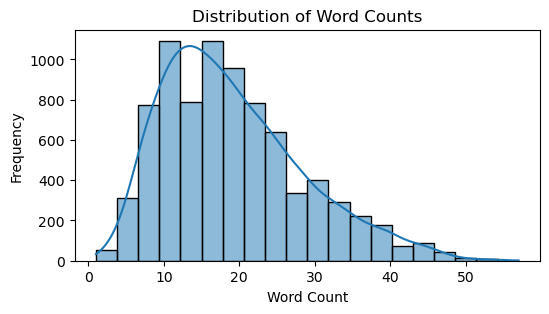

In [1506]:
# Plot the distribution for word count
plt.figure(figsize=(6,3))
sns.histplot(word_count_df['word_count'], bins=20, kde=True)
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

In [1507]:
#Drop the duplicate rows present in the dataframe
complaints.drop_duplicates(inplace=True)

/var/folders/vt/gsz9r5ls2bbdhx12jrgnq06r0000gn/T/ipykernel_3014/1491923888.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=complaints["Predict"], palette="Set2")


Text(0, 0.5, 'count')

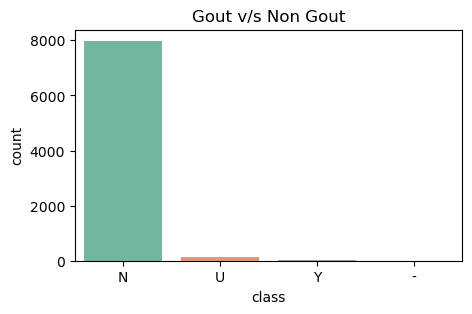

In [1508]:
#plot the distribution for predict column ( i.e yes/no)
plt.figure(figsize=(5,3))
sns.countplot(x=complaints["Predict"], palette="Set2")
plt.title('Gout v/s Non Gout')
plt.xlabel('class')
plt.ylabel('count')

In [1509]:
#count bigram pairs of consecutive words
vectorizer = CountVectorizer(ngram_range=(2,2) , stop_words="english")

In [1510]:
# Filter the DataFrame
filtered_complaints = complaints[complaints['Predict'] != 'N']

In [1511]:

# Apply the vectorizer to the filtered 'Chief Complaint' column
X = vectorizer.fit_transform(filtered_complaints['Chief Complaint'])
bigramFrequency = dict(zip(vectorizer.get_feature_names_out(), X.toarray().sum(axis = 0)))

In [1512]:
sortedBigrams = sorted(bigramFrequency.items(), key=lambda x:x[1], reverse=True)[:20]
print(sortedBigrams)

[('knee pain', 35), ('pain swelling', 27), ('foot pain', 23), ('denies injury', 17), ('denies trauma', 16), ('hip pain', 14), ('right knee', 12), ('pt states', 10), ('ankle pain', 9), ('left foot', 9), ('pmhx htn', 9), ('pmh htn', 8), ('hx htn', 7), ('pain weeks', 7), ('right foot', 7), ('big toe', 6), ('leg pain', 6), ('pain days', 6), ('pain x3', 6), ('pmh denies', 6)]


In [1513]:
keyword = set()
for Bigram, count in sortedBigrams:
    words = Bigram.split()
    keyword.update(words)

keyword = list(keyword)

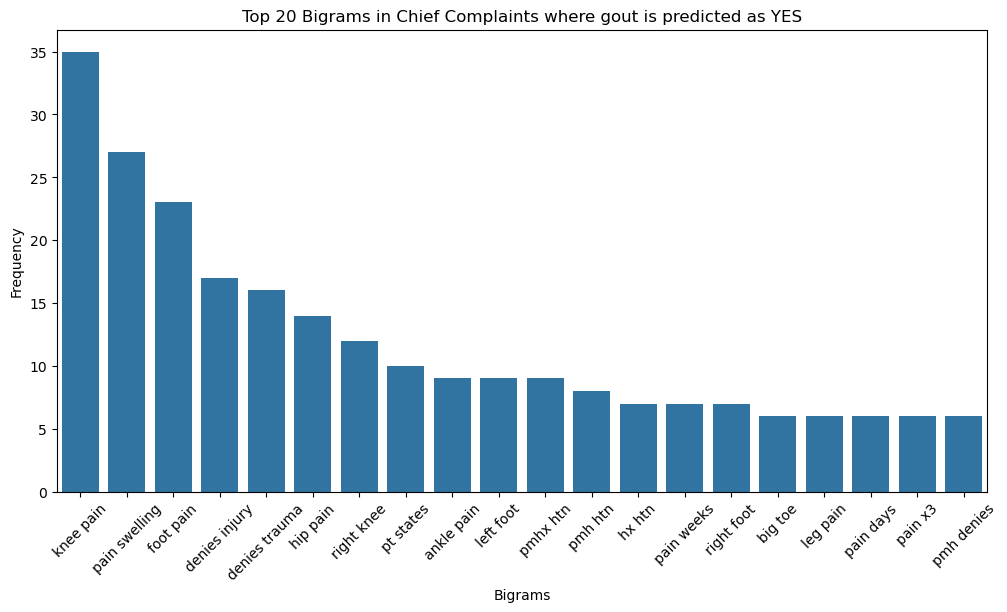

In [1514]:
plt.figure(figsize=(12, 6))
sns.barplot(x=[b[0] for b in sortedBigrams], y=[b[1] for b in sortedBigrams])
plt.xticks(rotation=45)
plt.title("Top 20 Bigrams in Chief Complaints where gout is predicted as YES")
plt.xlabel("Bigrams")
plt.ylabel("Frequency")
plt.show()

# 1. Data Preprocessing

# 1.1 Handling Abbrievations

In [1515]:
#Regular Expression For detecting Abbrivations

abbrievationPattern = r'\b(?:[A-Za-z]{2,}[A-Z0-9]+[A-Za-z0-9]*|[A-Za-z]+/[A-Za-z]+)\b'

In [1516]:
#This function is used to find the abbrievations
def findAbbrievation(text):
    regex = re.findall(abbrievationPattern, str(text))
    print(regex)
    return regex

In [1517]:
# the apply function implements the functions and returns abbrievations or shortforms of texts present in each line
abbrievation = complaints["Chief Complaint"].apply(findAbbrievation);  

['c/o', 'PMHX', 'PMHX']
['PMHX']
['c/o']
['EMS', 'UTD', 'PMHX']
[]
['abx/steroids', 'c/o', 'n/v']
[]
[]
[]
['MVC', 'LOC', 'PMHX']
['MVC', 'LOC']
[]
['PMH']
['PMHX', 'HTN']
['pain/swelling']
['DWMMH', 'c/o', 'PMHX', 'HTN', 'GERD']
['PMHX']
['N/V', 'PMHX', 'HTN']
[]
['EMS']
['c/o']
['c/o', 'MVC']
['c/o', 'motion/unable', 'd/t']
['c/o', 'PMHX', 'HTN']
['c/o']
['c/o', 'SOB']
['c/o', 'PMHX']
['c/o', 'v/d', 'PMHX']
['c/o']
['c/o']
['c/o']
['c/o']
['c/o']
['c/o']
['c/o', 'N/V', 'MVP']
['PMH']
[]
['c/o', 'OTC']
['c/o']
['c/o']
['EMS', 'HTN']
['c/o']
[]
['c/o']
['c/o']
['c/o']
['c/o', 'LMP']
['c/o']
['PMH']
['LMP', 'mar311971']
['PMH', 'ADHD']
['PMHX']
['PMHX', 'HTN']
['RMC', 'c/o', 'PMHX', 'COPD']
[]
['PMH']
['w/o', 'PMH']
['ALERT', 'GSW', 'DOE', 'MONKEY']
[]
['LMP']
['LMP']
['N/V', 'PMH', 'HTN']
[]
['SI/HI']
[]
['N/V']
[]
[]
['BLE', 'CHF', 'HTN']
['BLE', 'BUE']
['HTN']
[]
[]
[]
['OMH']
['C/o', 'AVH', 'PMH']
['C/o', 'c/o', 'PMH']
['AMS']
['SOB']
[]
['C/o', 'PMH']
['C/o', 'HTN']
['C/o']
['SOB',

In [1518]:
#Here we are creating a list and appending all the abbrievations variable present
allAbbrievations = [abbr for sublist in abbrievation for abbr in sublist]

# Counting occurrences of each abbreviation and appending it to the abbrievationCounter variable
abbrievationCounter = Counter(allAbbrievations)

In [1519]:
#Here we are creating a dictionary which hasall the necessary and frequently repeated abbrievations and ts full form
abbrievationList = {
    "c/o": "complains of",
    "C/O": "complains of",
    "C/o": "complains of",
    "PMH": "past medical history",
    "PMHX": "past medical history",
    "PMHx": "past medical history",
    "HTN": "hypertension",
    "SOB": "shortness of breath",
    "N/V": "nausea and vomiting",
    "n/v": "nausea and vomiting",
    "LOC": "loss of consciousness",
    "EMS": "emergency medical services",
    "CHF": "congestive heart failure",
    "COPD": "chronic obstructive pulmonary disease",
    "HIV": "human immunodeficiency virus",
    "SI/HI": "suicidal ideation or homicidal ideation",
    "si/hi": "suicidal ideation or homicidal ideation",
    "PCP": "primary care physician",
    "PTA": "prior to arrival",
    "UTI": "urinary tract infection",
    "GERD": "gastroesophageal reflux disease",
    "LMP": "last menstrual period",
    "RLQ": "right lower quadrant",
    "d/t": "due to",
    "CVA": "cerebrovascular accident",
    "HLD": "hyperlipidemia",
    "LLQ": "left lower quadrant",
    "RUQ": "right upper quadrant",
    "LLE": "left lower extremity",
    "s/p": "status post",
    "w/o": "without",
    "w/out": "without",
    "GSW": "gunshot wound",
    "s/s": "signs and symptoms",
    "PTSD": "post-traumatic stress disorder",
    "BLE": "both lower extremities",
    "CKD": "chronic kidney disease",
    "AVH": "auditory or visual hallucinations",
    "ESRD": "end-stage renal disease",
    "ETOH": "ethanol",
    "DVT": "deep vein thrombosis",
    "DVTs": "deep vein thrombosis",
    "OTC": "over the counter",
    "UTD": "up to date",
    "MVA": "motor vehicle accident",
    "URI": "upper respiratory infection",
    "LUQ": "left upper quadrant",
    "STD": "sexually transmitted disease",
    "STDs": "sexually transmitted diseases",
    "r/t": "related to",
    "CABG": "coronary artery bypass graft",
    "NVD": "nausea, vomiting, diarrhea",
    "IBS": "irritable bowel syndrome",
    "RLE": "right lower extremity",
    "ADHD": "attention-deficit or hyperactivity disorder",
    "CAD": "coronary artery disease",
    "AMS": "altered mental status",
    "DM2": "diabetes mellitus type 2",
    "DMII": "diabetes mellitus type 2",
    "dm2": "diabetes mellitus type 2",
    "DM1": "diabetes mellitus type 1",
    "dm1": "diabetes mellitus type 1",
    "ABD": "abdomen",
    "TBI": "traumatic brain injury",
    "d/c": "discontinue or discharge",
    "d/ced": "discontinue or discharge",
    "ROM": "range of motion",
    "MRI": "magnetic resonance imaging",
    "IUD": "intrauterine device",
    "MVP": "mitral valve prolapse",
    "MET": "metabolic equivalent of task",
    "BRB": "bright red blood",
    "BRBPR": "bright red blood per rectum",
    "LUE": "left upper extremity",
    "ENT": "ear, nose, and throat",
    "PMD": "past medical doctor",
    "PCOS": "polycystic ovary syndrome",
    "SCC": "squamous cell carcinoma",
    "PNA": "pneumonia",
    "NMC": "no medical complaints",
    "SVT": "supraventricular tachycardia",
    "TIA": "transient ischemic attack",
    "DOE": "dyspnea on exertion",
    "Ox3": "alert and oriented x3",
    "ox3": "alert and oriented x3",
    "OX3": "alert and oriented x3",
    "aox3": "alert and oriented x3",
    "aox4": "alert and oriented x4",
    "AOX4": "alert and oriented x4",
    "Ox4": "alert and oriented x4",
    "ox4": "alert and oriented x4",
    "AOx4": "alert and oriented x4",
    "AOx3": "alert and oriented x3",
    "PICC": "peripherally inserted central catheter",
    "ASA": "acetylsalicylic acid",
    "LBP": "lower back pain",
    "EKG": "electrocardiogram",
    "ECG": "electrocardiogram",
    "PEG": "percutaneous endoscopic gastrostomy",
    "TDAP": "tetanus, diphtheria, acellular pertussis vaccine",
    "r/o": "rule out",
    "R/O": "rule out",
    "PmHx": "past medical history",
    "SYM": "symptom",
    "BKA": "below knee amputation",
    "PTE": "pulmonary thromboembolism",
    "LWBS": "left without being seen",
    "RUE": "right upper extremity",
    "ABX": "antibiotics",
    "abx": "antibiotics",
    "b/c": "because",
    "RLS": "restless leg syndrome",
    "BUE": "both upper extremities",
    "IVDU": "intravenous drug use",
    "OBGYN": "obstetrics and gynecology",
    "OB/GYN": "obstetrics and gynecology",
    "BPH": "benign prostatic hyperplasia",
    "HEP": "Hepatitis",
    "OSA": "obstructive sleep apnea",
    "DJD": "degenerative joint disease",
    "f/u": "follow up",
    "AKA": "above knee amputation",
    "CPAP": "continuous positive airway pressure",
    "FSBS": "finger stick blood sugar",
    "PVD": "peripheral vascular disease",
    "AMA": "against medical advice",
    "WBC": "white blood cell",
    "MRSA": "methicillin-resistant Staphylococcus aureus",
    "NRB": "non-rebreather",
    "WOB": "work of breathing",
    "IVC": "inferior vena cava",
    "EGD": "esophagogastroduodenoscopy",
    "AAA": "abdominal aortic aneurysm",
    "AFIB": "atrial fibrillation",
    "afib": "atrial fibrillation",
    "GCS": "Glasgow Coma Scale",
    "NASH": "nonalcoholic steatohepatitis",
    "UED": "upper extremity, distal",
    "HPV": "human papillomavirus",
    "PAD": "peripheral artery disease",
    "MVC": "Motor Vehicle Collision",
    "POTS": "Postural Orthostatic Tachycardia Syndrome",
    "CPR": "Cardiopulmonary Resuscitation",
    "ICD": "Implantable Cardioverter Defibrillator",
    "CXR": "Chest X-Ray",
    "ARDS": "Acute Respiratory Distress Syndrome",
    "BID": "Twice a Day",
    "SCD": "Sickle Cell Disease or Sudden Cardiac Death",
    "OCD": "Obsessive-Compulsive Disorder",
    "FSBG": "Finger Stick Blood Glucose",
    "ICU": "Intensive Care Unit",
    "IUP": "Intrauterine Pregnancy",
    "RSV": "Respiratory Syncytial Virus",
    "SDH": "Subdural Hematoma",
    "HCTZ": "Hydrochlorothiazide",
    "HCV": "Hepatitis C Virus",
    "THA": "Total Hip Arthroplasty",
    "PIV": "Peripheral Intravenous Line",
    "PUD": "Peptic Ulcer Disease",
    "UOP": "Urine Output",
    "ALT": "Alanine Aminotransferase",
    "AAO": "Alert and Oriented",
    "IDDM": "Insulin-Dependent Diabetes Mellitus",
    "WPW": "Wolff-Parkinson-White Syndrome",
    "PPMS": "Primary Progressive Multiple Sclerosis",
    "PMS": "Premenstrual Syndrome",
    "ICA": "Internal Carotid Artery",
    "ICH": "Intracerebral Hemorrhage",
    "SBO": "Small Bowel Obstruction",
    "STI": "Sexually Transmitted Infection",
    "CVID": "Common Variable Immunodeficiency",
    "STEMI": "ST-Elevation Myocardial Infarction",
    "SCI": "Spinal Cord Injury",
    "ITP": "Immune Thrombocytopenic Purpura",
    "EDD": "Estimated Due Date",
    "IVD": "Intravenous Drug Use",
    "APAP": "Acetaminophen",
    "BBB": "Bundle Branch Block",
    "ADL": "Activities of Daily Living",
    "ANA": "Antinuclear Antibody",
    "VSS": "Vital Signs Stable",
    "CRP": "C-Reactive Protein"
}

In [1520]:
#Replacing the abbrievations with its correct meaning for this we are using .str.replace to the dataframe[column]
#case = False ensures that text being replaced is case insensitive
#regex = False ensures that '/' is not treated as a regular expression

for keys in abbrievationList:
    complaints["Chief Complaint"] = complaints["Chief Complaint"].str.replace(keys,abbrievationList[keys],case=False, regex=False)

In [1521]:
#'/' in the rows is being replaced with or
complaints["Chief Complaint"] = complaints["Chief Complaint"].str.replace("/"," or ",case=False, regex=False)

In [1522]:
#we use lambda function which takes each row and applies strip function to remove spaces at starting and ending of the row for all the lines

complaints["Chief Complaint"] = complaints["Chief Complaint"].apply(lambda x : x.strip())

In [1523]:
#complaints.columns = complaints.columns.str.replace(' ', '')

# 1.2 LowerCasing

In [1524]:
complaints['Chief Complaint'] = complaints['Chief Complaint'].str.lower()

In [1525]:
complaints

,Chief Complaint,Predict,Consensus
0,"""i dont know whats going on with my head, its ...",N,-
1,"""i've been depressed for a few weeks now, i'm ...",N,-
2,alanine aminotransferaseercation while making ...,N,N
3,cut on l upper thigh wtih saw. both lower extr...,N,N
4,dysupper respiratory infectiona x1 week. hx: h...,N,-
...,...,...,...
8132,"stepped on a nail at home with right foot, pai...",N,N
8133,""" i was having a breakdown."" related to stress...",N,-
8134,"""i tried to jump in front of a car"" pt states ...",N,-
8135,abdomenominal pain x 1 week. denies past medin...,N,-


# 1.3 Punctuation Removal

In [1526]:
def punctuationRemoval(text):
    text = str(text)
    
    #string.punctuation contains all the punctuations and str.maketrans will map each translation table to None
    return text.translate(str.maketrans('', '', string.punctuation))

In [1527]:
complaints['Chief Complaint'] = complaints['Chief Complaint'].apply(punctuationRemoval)

In [1528]:
complaints

,Chief Complaint,Predict,Consensus
0,i dont know whats going on with my head its no...,N,-
1,ive been depressed for a few weeks now im also...,N,-
2,alanine aminotransferaseercation while making ...,N,N
3,cut on l upper thigh wtih saw both lower extre...,N,N
4,dysupper respiratory infectiona x1 week hx hys...,N,-
...,...,...,...
8132,stepped on a nail at home with right foot pain...,N,N
8133,i was having a breakdown related to stress an...,N,-
8134,i tried to jump in front of a car pt states sh...,N,-
8135,abdomenominal pain x 1 week denies past medint...,N,-


# 1.4 Stopword Removal

In [1529]:
stopWords = set(stopwords.words('english'))

In [1530]:
def stopwordRemoval(text):
    text = str(text)
    word_tokens = nltk.word_tokenize(text)
    filtered_words = [word for word in word_tokens if word not in stopWords]
    return " ".join(filtered_words)
    

In [1531]:
complaints['Chief Complaint'] = complaints['Chief Complaint'].apply(stopwordRemoval)

In [1532]:
complaints

,Chief Complaint,Predict,Consensus
0,dont know whats going head regular ha passed h...,N,-
1,ive depressed weeks im also coming herion thou...,N,-
2,alanine aminotransferaseercation making arrest...,N,N
3,cut l upper thigh wtih saw lower extremitiesed...,N,N
4,dysupper respiratory infectiona x1 week hx hys...,N,-
...,...,...,...
8132,stepped nail home right foot painful diffinten...,N,N
8133,breakdown related stress depression,N,-
8134,tried jump front car pt states psych meds past...,N,-
8135,abdomenominal pain x 1 week denies past medint...,N,-


# 1.5 Lemmatization

In [1533]:
lemmatizer = WordNetLemmatizer()

In [1534]:
def get_wordnet_pos(tag):
    # Helper function to convert NLTK's part-of-speech tags to WordNet's format.
    # Think of it as a translator telling the lemmatizer the word's job.
    if tag.startswith('J'):
        return 'a'  # J means adjective
    elif tag.startswith('V'):
        return 'v'  # V means verb
    elif tag.startswith('N'):
        return 'n'  # N means noun
    elif tag.startswith('R'):
        return 'r'  # R means adverb
    else:
        return 'n'  # Default to noun if the job isn't clear

In [1535]:
def lemmatize_text(text):
    text = str(text)
    word_tokens = nltk.word_tokenize(text)
    tagged_words = pos_tag(word_tokens)  # Label each word with its job (using secret codes)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag))  # Find the base form, using the translated job label
                        for word, tag in tagged_words]
    return " ".join(lemmatized_words)

In [1536]:
complaints['Chief Complaint'] = complaints['Chief Complaint'].apply(lemmatize_text)

# Bigram Analysis

In [1537]:
#Filtering U and - in consensus column to filteredDF
filteredDF = complaints[complaints["Consensus"].isin(["U","-"])]

In [1538]:
def replaceUnknownInConsensus(row):
    # Check if any keyword is present in the "Chief complaint" column and replace U or - with Y or N to filteredDF
    if any(word.lower() in row["Chief Complaint"].lower() for word in keyword):
        return "Y"
    else:
        return "N"

In [1539]:
# Apply the function row-wise (axis=1)
filteredDF["Consensus"] = filteredDF.apply(replaceUnknownInConsensus, axis=1)

/var/folders/vt/gsz9r5ls2bbdhx12jrgnq06r0000gn/T/ipykernel_3014/2156826006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filteredDF["Consensus"] = filteredDF.apply(replaceUnknownInConsensus, axis=1)


In [1540]:
#replace U or - with values values in filteredDF
complaints.loc[complaints["Consensus"].isin(["U", "-"]), :] = filteredDF

In [1541]:
#replace U or - with values values in consensus column so that expert opinion is much better than machine predicted values
complaints.loc[complaints["Predict"].isin(["U", "-"]), "Predict"] = complaints["Consensus"]

In [1542]:
#replace N with values values in consensus column so that expert opinion is much better than machine predicted values
complaints.loc[complaints["Predict"].isin(["N"]), "Predict"] = complaints["Consensus"]

In [1543]:
complaints

,Chief Complaint,Predict,Consensus
0,dont know whats go head regular ha pass home b...,Y,Y
1,ive depressed week im also come herion thought...,N,N
2,alanine aminotransferaseercation make arrest c...,N,N
3,cut l upper thigh wtih saw low extremitiesedin...,N,N
4,dysupper respiratory infectiona x1 week hx hys...,Y,Y
...,...,...,...
8132,stepped nail home right foot painful diffinten...,N,N
8133,breakdown related stress depression,N,N
8134,tried jump front car pt state psych med past m...,Y,Y
8135,abdomenominal pain x 1 week denies past medint...,Y,Y


# 1.6 Tokenization

In [1544]:
# 5. Tokenization
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token="<unk>")
tokenizer.fit_on_texts(complaints['Chief Complaint'])
sequences = tokenizer.texts_to_sequences(complaints['Chief Complaint'])

# 1.7 Padding

In [1545]:
maxlength = 100
padded_sequences = pad_sequences(sequences, maxlen=maxlength, padding='post', truncating='post')

print(f"Vocabulary size: {len(tokenizer.word_index) + 1}")
print(f"Padded sequences shape: {padded_sequences.shape}")

Vocabulary size: 7912
Padded sequences shape: (8131, 100)


In [1546]:
# 7. Prepare the target variable
complaints['PredictBinary'] = complaints['Predict'].map({'Y': 1, 'N': 0})
labels = complaints['PredictBinary'].values

# 1.8 Removing Null Values

In [1547]:
print(complaints['PredictBinary'].unique())
print(complaints['PredictBinary'].isnull().sum())

[1 0]
0


In [1548]:
# Identify rows where 'PredictBinary' is NaN
nanRows = complaints[complaints['PredictBinary'].isnull()].index
complaints.drop(nanRows, inplace=True)

In [1549]:
removed_indices = nanRows.tolist()

In [1550]:
X = np.delete(padded_sequences, removed_indices, axis=0)
y = complaints['PredictBinary'].values

# 2 Train-Test Split

In [1551]:
# Stratified split: 80% train, 20% val
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_idx, val_idx in strat_split.split(X, y):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

# Check label distribution
from collections import Counter
print("Train label distribution:", Counter(y_train))
print("Val label distribution:", Counter(y_val))

Train label distribution: Counter({1: 4499, 0: 1192})
Val label distribution: Counter({1: 1929, 0: 511})


In [1552]:
print(f"Training set size: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation set size: X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Validation set size: X_val: {X_val.shape}, y_val: {y_val.shape}")

Training set size: X_train: (5691, 100), y_train: (5691,)
Validation set size: X_val: (2440, 100), y_val: (2440,)
Validation set size: X_val: (2440, 100), y_val: (2440,)


# 3 Data Balancing Using SMOTE

In [1553]:
# 9. Data Balancing (using SMOTE on training data)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [1554]:
print("\nTraining data shape after SMOTE:")
print(f"X_train_smote: {X_train_smote.shape}, y_train_smote: {y_train_smote.shape}")


Training data shape after SMOTE:
X_train_smote: (8998, 100), y_train_smote: (8998,)


In [1555]:
print("Balanced training label distribution:", Counter(y_train_smote))

Balanced training label distribution: Counter({1: 4499, 0: 4499})


# 4. Building LSTM Model

In [1556]:
# Get the vocabulary size (make sure this has been run AFTER fitting the tokenizer)
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 7912


In [1557]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlength),
    GlobalAveragePooling1D(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.build(input_shape=(None, maxlength))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

/Users/tinkuacchu/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_74 (Embedding)        │ (None, 100, 128)       │     1,012,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_11     │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_112 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,021,057 (3.90 MB)

 Trainable params: 1,021,057 (3.90 MB)

 Non-trainable params: 0 (0.00 B)

In [1558]:
history = model.fit(
    X_train_smote, y_train_smote,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5230 - loss: 0.6899 - val_accuracy: 0.7611 - val_loss: 0.6433
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6796 - loss: 0.6238 - val_accuracy: 0.8307 - val_loss: 0.4326
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7499 - loss: 0.5070 - val_accuracy: 0.7168 - val_loss: 0.5306
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7940 - loss: 0.4497 - val_accuracy: 0.8660 - val_loss: 0.3638
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8004 - loss: 0.4353 - val_accuracy: 0.7320 - val_loss: 0.5192
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8125 - loss: 0.4119 - val_accuracy: 0.5873 - val_loss: 0.7656
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8290 - loss: 0.3928 - val_accuracy: 0.8762 - val_loss: 0.3367
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8378 - loss: 0.3826 - val_accuracy: 0.

In [1559]:
y_pred = (model.predict(X_val) > 0.5).astype("int32")

print("Classification Report for GlobalAveragePooling1D Model :")
print(classification_report(y_val, y_pred))

print("Confusion Matrix for GlobalAveragePooling1D Model :")
print(confusion_matrix(y_val, y_pred))

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step
Classification Report for GlobalAveragePooling1D Model :
              precision    recall  f1-score   support

           0       0.63      0.81      0.71       511
           1       0.94      0.87      0.91      1929

    accuracy                           0.86      2440
   macro avg       0.79      0.84      0.81      2440
weighted avg       0.88      0.86      0.87      2440

Confusion Matrix for GlobalAveragePooling1D Model :
[[ 412   99]
 [ 243 1686]]


In [1560]:
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlength),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
# Build the model

model_lstm.build(input_shape=(None, maxlength))

model_lstm.compile(loss='binary_crossentropy',
                   optimizer=Adam(learning_rate=0.002),
                   metrics=['accuracy'])

model_lstm.summary()

/Users/tinkuacchu/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_75 (Embedding)        │ (None, 100, 128)       │     1,012,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 100, 128)       │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,210,497 (4.62 MB)

 Trainable params: 1,210,497 (4.62 MB)

 Non-trainable params: 0 (0.00 B)

In [1561]:
history_lstm = model_lstm.fit(
    X_train_smote, y_train_smote,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.7256 - loss: 0.5204 - val_accuracy: 0.8189 - val_loss: 0.4260
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.9103 - loss: 0.2358 - val_accuracy: 0.8643 - val_loss: 0.3552
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 0.9466 - loss: 0.1641 - val_accuracy: 0.8516 - val_loss: 0.4532
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 0.9685 - loss: 0.1061 - val_accuracy: 0.8582 - val_loss: 0.4579
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9785 - loss: 0.0710 - val_accuracy: 0.8799 - val_loss: 0.4411
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9852 - loss: 0.0468 - val_accuracy: 0.8873 - val_loss: 0.4357
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9859 - loss: 0.0506 - val_accuracy: 0.8766 - val_loss: 0.4921
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9930 - loss: 0.

In [1562]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming you have trained your model_lstm and have your validation data (X_val, y_val)

# Predict on the validation set using the trained LSTM model
y_pred_lstm = (model_lstm.predict(X_val) > 0.5).astype("int32")

# Print the classification report
print("Classification Report for LSTM Model (Validation Set):")
print(classification_report(y_val, y_pred_lstm))

# Print the confusion matrix
print("\nConfusion Matrix for LSTM Model (Validation Set):")
print(confusion_matrix(y_val, y_pred_lstm))

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Classification Report for LSTM Model (Validation Set):
              precision    recall  f1-score   support

           0       0.61      0.83      0.70       511
           1       0.95      0.86      0.90      1929

    accuracy                           0.85      2440
   macro avg       0.78      0.84      0.80      2440
weighted avg       0.88      0.85      0.86      2440


Confusion Matrix for LSTM Model (Validation Set):
[[ 423   88]
 [ 272 1657]]


In [1563]:
model_cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlength),
    Conv1D(128, 3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_cnn.build(input_shape=(None, maxlength))

model_cnn.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

model_cnn.summary()

/Users/tinkuacchu/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_76 (Embedding)        │ (None, 100, 128)       │     1,012,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_34 (Conv1D)              │ (None, 98, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_34         │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,070,337 (4.08 MB)

 Trainable params: 1,070,337 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

In [1564]:
history_cnn = model_cnn.fit(
    X_train_smote, y_train_smote,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7067 - loss: 0.5445 - val_accuracy: 0.9189 - val_loss: 0.2659
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9474 - loss: 0.1678 - val_accuracy: 0.9311 - val_loss: 0.2228
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9809 - loss: 0.0812 - val_accuracy: 0.9299 - val_loss: 0.2297
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9899 - loss: 0.0389 - val_accuracy: 0.9205 - val_loss: 0.2606
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9961 - loss: 0.0201 - val_accuracy: 0.9275 - val_loss: 0.2749
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9987 - loss: 0.0089 - val_accuracy: 0.9193 - val_loss: 0.2983
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9997 - loss: 0.0036 - val_accuracy: 0.9172 - val_loss: 0.3278
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9995 - loss: 0.0028 - val_accuracy: 0

In [1565]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_cnn = (model_cnn.predict(X_val) > 0.5).astype("int32")

print("Classification Report for CNN Model (Validation Set):")
print(classification_report(y_val, y_pred_cnn))

print("\nConfusion Matrix for CNN Model (Validation Set):")
print(confusion_matrix(y_val, y_pred_cnn))

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification Report for CNN Model (Validation Set):
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       511
           1       0.95      0.95      0.95      1929

    accuracy                           0.92      2440
   macro avg       0.89      0.88      0.88      2440
weighted avg       0.92      0.92      0.92      2440


Confusion Matrix for CNN Model (Validation Set):
[[ 411  100]
 [  89 1840]]


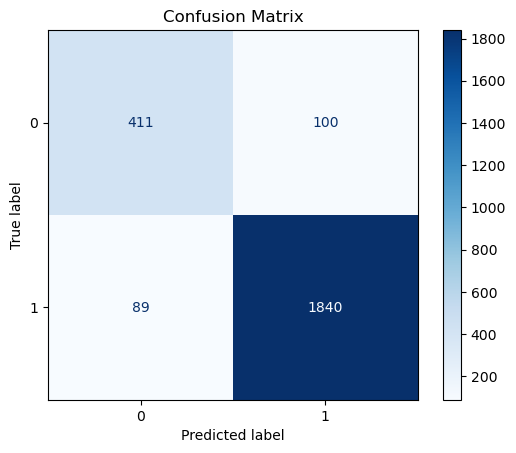

In [1566]:
cm = confusion_matrix(y_val, y_pred_cnn)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()